<a href="https://colab.research.google.com/github/sheramir/MIT-DS/blob/main/Malaria_Detection_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
Malaria is a lethal disease. Early and accurate diagnosis is crucial for effective treatment and reducing mortality rates. Traditional examination is time-consuming, requires trained professionals, and is prone to human error. Automating malaria detection using deep learning can enhance diagnostic accuracy, reduce workload for medical professionals, and improve accessibility in resource-limited settings.


**The objectives:** What is the intended goal?<br>
The primary goal is to develop a CNN-based AI model that can accurately classify blood cell images as either parasitized or uninfected.

**The key questions:** What are the key questions that need to be answered?<br>

1.	How accurately can the CNN model classify parasitized and uninfected blood cells?

2.	What is the optimal model (architecture and hyperparameters) for achieving the best performance?

3.	What preprocessing techniques are necessary to enhance model performance?


**The problem formulation:** What is it that we are trying to solve using data science?<br>

The problem is a binary classification task where the goal is to train a CNN model to classify colored blood cell images into two categories: parasitized or uninfected. The dataset consists of labeled microscopic images, and the challenge involves designing a deep learning pipeline that includes data preprocessing, model training, evaluation, and testing.

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### <b>Loading libraries</b>

In [2]:
# Importing libraries for files and images processing
# Libraries for Neural-Networks will be imported later

import numpy as np


# Files handling libraries
import os
from zipfile import ZipFile

from tqdm import tqdm

# Images handling library
import cv2


# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize random seed
import random
np.random.seed(42)
random.seed(42)


### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [3]:
# The zip file is in a permanent Google drive
# The files are extracted and put in a temporary drive in each session

zip_file_path = '/content/drive/MyDrive/ADSP/Malaria Detection/cell_images.zip'
data_path = '/content/cell_images'


# Check if data was already extracted from zip file
if not os.path.exists(data_path):
  # Open the zip file
  with ZipFile(zip_file_path, 'r') as zip:
    zip.extractall()
    print('Data was extracted to', data_path)
else:
  print('Data was already extracted to', data_path)

Data was already extracted to /content/cell_images


The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [4]:
# Function that loads the images from either 'train' or 'test' folders
# and returns numpy arrays of X and y
def load_dataset(folder_path, group='test', img_size = 64):
    X = []
    y = []
    categories = ['parasitized', 'uninfected']

    for category in categories:
        path = os.path.join(folder_path, group, category)
        print (f'Reading images from {path}')
        for img in tqdm(os.listdir(path)):

            # Read the image files
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)

            # Resize the image to uniform size
            img_array = cv2.resize(img_array, (img_size, img_size))

            # Convert to RGB (cv2 use BGR by default)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

            # Add image to list
            X.append(img_array)

            # Create binary labels
            y.append(0 if category == 'uninfected' else 1)

    return np.array(X), np.array(y) # return as numpy arrays


In [5]:
X_train, y_train = load_dataset(data_path, group='train')
X_test, y_test = load_dataset(data_path, group='test')

Reading images from /content/cell_images/train/parasitized


100%|██████████| 12582/12582 [00:11<00:00, 1133.83it/s]


Reading images from /content/cell_images/train/uninfected


100%|██████████| 12376/12376 [00:07<00:00, 1552.40it/s]


Reading images from /content/cell_images/test/parasitized


100%|██████████| 1300/1300 [00:01<00:00, 974.00it/s]


Reading images from /content/cell_images/test/uninfected


100%|██████████| 1300/1300 [00:00<00:00, 1396.90it/s]


###<b> Check the shape of train and test images

In [6]:
print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)

Shape of X_train:  (24958, 64, 64, 3)
Shape of X_test:  (2600, 64, 64, 3)


###<b> Check the shape of train and test labels

In [7]:
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of y_train:  (24958,)
Shape of y_test:  (2600,)


####<b> Observations and insights</b>:
1. Number of train samples: 24958
2. Number of test samples: 2600
3. Images size: 64X64 with 3 RGB channels

### <b>Check the minimum and maximum range of pixel values for train and test images

In [8]:
print('X_train pixels range: ', X_train.min(),'-' , X_train.max())
print('X_test pixels range: ', X_test.min(),'-' , X_test.max())


X_train pixels range:  0 - 255
X_test pixels range:  0 - 255


####<b> Observations and insights:</b>
Images pixel values are between 0-255. Images should be normalized to 0-1.



###<b>Normalize the images

In [9]:
if X_train.max() > 1:   # Don't normalize more than once
  X_train = (X_train/255).astype('float32') # need to convert to float32 for later cv2 conversions
if X_test.max() > 1:
  X_test = (X_test/255).astype('float32')

print('X_train pixels range: ', X_train.min(),'-' , X_train.max())
print('X_test pixels range: ', X_test.min(),'-' , X_test.max())

X_train pixels range:  0.0 - 1.0
X_test pixels range:  0.0 - 1.0


####<b> Observations and insights:</b>
Images are normalized- pixel values between 0-1

###<b> Count the number of values in both uninfected and parasitized

In [10]:
labels_train, counts_train = np.unique(y_train, return_counts=True)
print('Train set - Number of uninfected images: ', counts_train[0])
print('Train set - Number of parasitized images: ', counts_train[1])

labels_test, counts_test = np.unique(y_test, return_counts=True)
print('Test set - Number of uninfected images: ', counts_test[0])
print('Test set - Number of parasitized images: ', counts_test[1])

Train set - Number of uninfected images:  12376
Train set - Number of parasitized images:  12582
Test set - Number of uninfected images:  1300
Test set - Number of parasitized images:  1300


###<b> Plot to check if the data is balanced

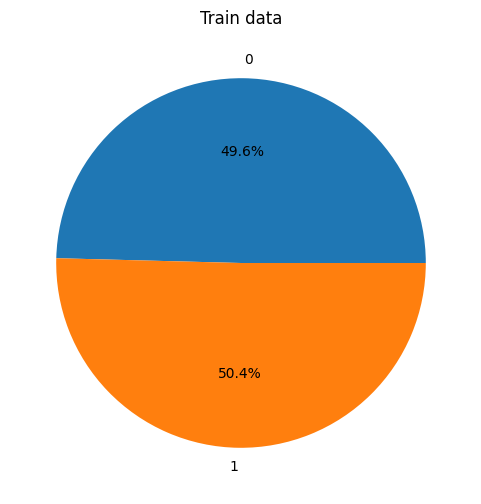

In [11]:
# Draw pie charts of y_train to check if data is balanced

plt.figure(figsize=(6, 6))
plt.pie(counts_train, labels=labels_train, autopct='%1.1f%%')
plt.title('Train data')
plt.show()


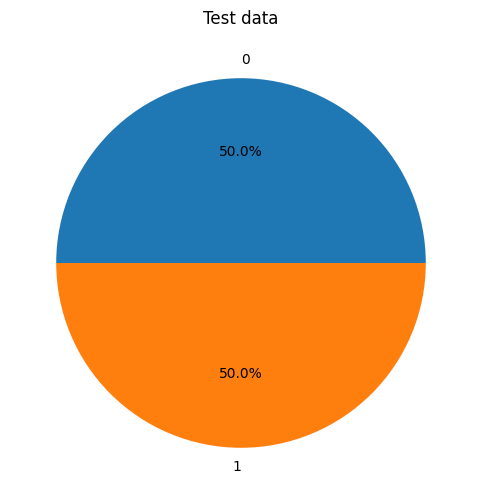

In [12]:
# Draw pie charts of y_test to check if data is balanced

plt.figure(figsize=(6, 6))
plt.pie(counts_test, labels=labels_test, autopct='%1.1f%%')
plt.title('Test data')
plt.show()


####<b> Observations and insights</b>:

The data is balanced around 50% of each class.

### <b>Data Exploration</b>
Let's visualize the images from the train data

In [13]:
# A function that plots a grid of images

np.random.seed(42)

def plot_images_grid(X, y, row=4, col=4, figsize=(8,8), randomize=True, balance=True):
  """Plots a grid of images selected from X with corresponding labels from y.

  Args:
    X: A NumPy array of images.
    y: A NumPy array of labels corresponding to the images in X.
    row: The number of rows in the image grid. Defaults to 4.
    col: The number of columns in the image grid. Defaults to 4.
    figsize: The size of the figure to be plotted. Defaults to (8, 8).
    randomize: A boolean indicating whether to randomize the selection of images.
               Defaults to True.
    balance: A boolean indicating whether to balance the number of images
             from each class. Defaults to True.
  """
  total_images = min(row * col,len(X))
  half = int(total_images/2)
  X_plot = []
  y_plot = []

  # Extract images from X,y and put in X_plot,y_plot
  for i in range(len(X)):

    # Set index to be random or incremental
    if randomize:
      indx = np.random.randint(0, len(X)) # Get random images
    else:
      indx = i  # Get incremental images

    # Add uninfected cell image
    if y[indx] == 0:
      if (balance and y_plot.count('uninfected') < half) or not balance:
        X_plot.append(X[indx])
        y_plot.append('uninfected')

    # Add parasitized cell image
    if y[indx] == 1:
      if (balance and y_plot.count('parasitized') < (total_images - half)) or not balance:
        X_plot.append(X[indx])
        y_plot.append('parasitized')

    # Exit loop if enough images in X_plot
    if len(X_plot) == total_images:
      break

  plt.figure(figsize=figsize)
  for i in range(total_images):
    plt.subplot(row, col, i+1)
    plt.imshow(X_plot[i])
    plt.title(y_plot[i])
    plt.axis('off')
  plt.show()

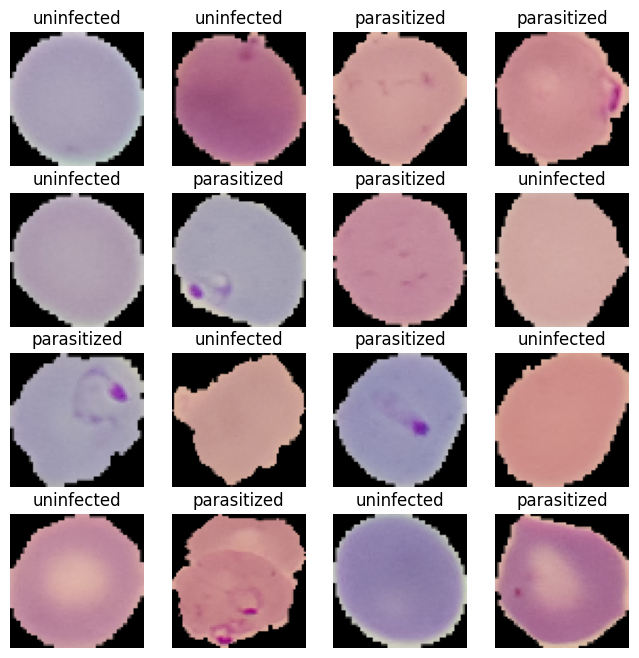

In [14]:
plot_images_grid(X_train, y_train, 4, 4)

####<b> Observations and insights:</b>
- Parasited cells appear to have distinct spots.
- The color of the cells is ranging between red, orange, blue, purple. The color however is not indicating of parasited cells.


###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

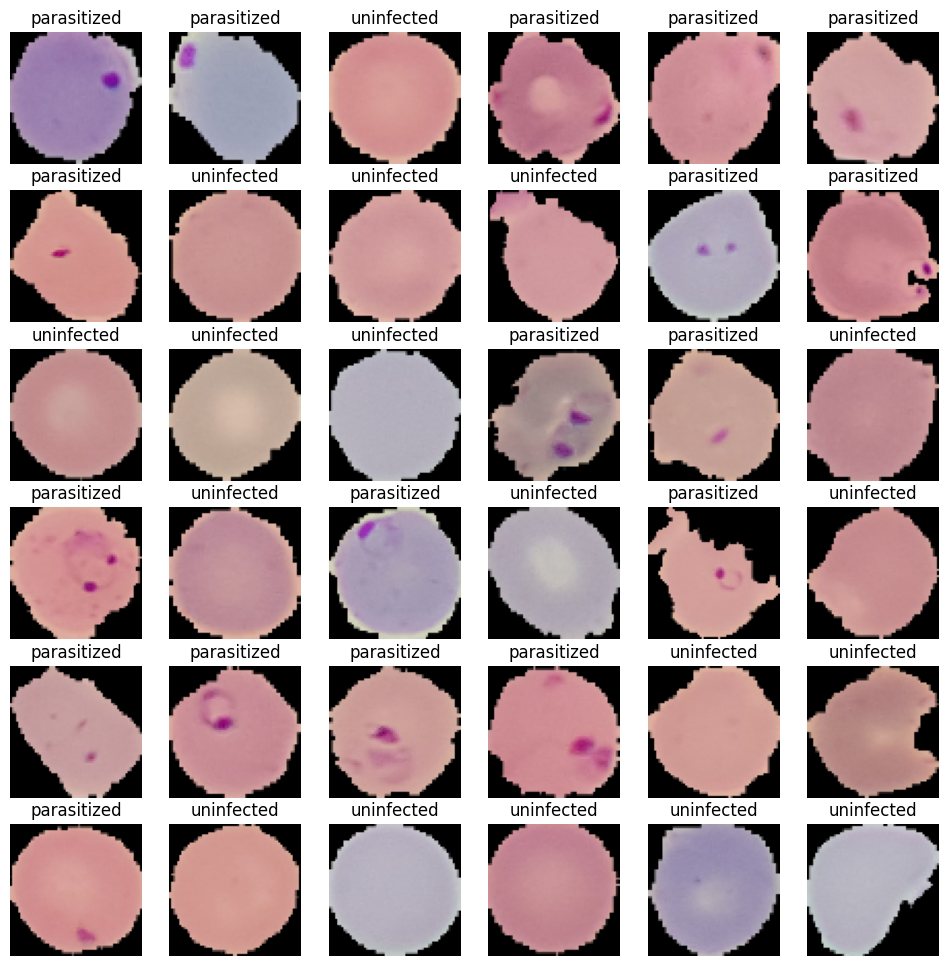

In [15]:
plot_images_grid(X_train, y_train, 6, 6, figsize=(12, 12))



####<b> Observations and insights:</b>
- Parasited cells appear to have distinct red/purple spots.
- The color of the cells is ranging between red, pink, orange, blue, purple. The color however is not indicating of parasited cells.

###<b> Plotting the mean images for parasitized and uninfected

In [16]:
# Seperate samples for parasitized and uninfected
parasitized_data = X_train[y_train == 1]
uninfected_data = X_train[y_train == 0]

print ('Number of parasitizied samples:', parasitized_data.shape[0])
print ('Number of uninfected samples:', uninfected_data.shape[0])

Number of parasitizied samples: 12582
Number of uninfected samples: 12376


In [17]:
# Calculate mean images of samples for each group
parasitized_mean = np.mean(parasitized_data, axis=0)
uninfected_mean = np.mean(uninfected_data, axis=0)
train_all_mean = np.mean(X_train, axis=0)

In [18]:
# Function to show image
def show_mean(img, title):

    plt.imshow(img)
    plt.title(f'Mean {title}')
    plt.axis('off')
    plt.show()

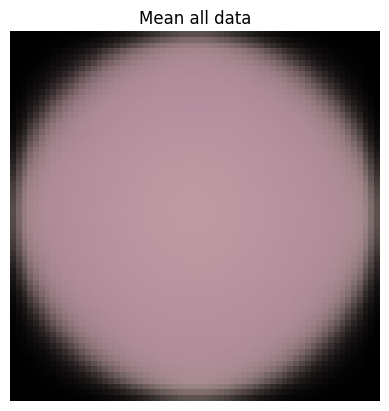

In [19]:
show_mean(train_all_mean, 'all data')

In [20]:
# Plot mean of images in different sample size increments

np.random.seed(42)

def show_mean_increment(images, title, sample_list = [5,10,50,-1]):

  col = 2
  row = int(len(sample_list) /2)

  images_copy = images.copy() # keep a copy so array won't reshuffled outside function

  np.random.shuffle(images_copy)  # randomize order of images
  plt.figure(figsize=(6,6))

  for i,num in enumerate(sample_list):
    plt.subplot(row, col, i+1)
    img_mean = np.mean(images_copy[0:num], axis=0)
    plt.imshow(img_mean)
    if num == -1:
      num = 'all'
    plt.title(f'Mean {num} {title}')
    plt.axis('off')
  plt.show()

  del images_copy # delete variable to save memory

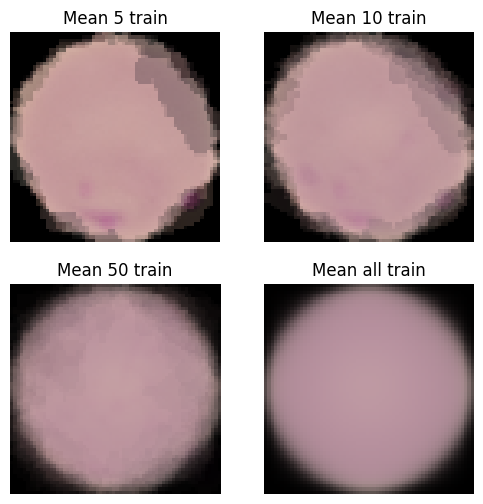

In [21]:
# Show mean of different image samples from all train data
show_mean_increment(X_train, 'train', sample_list = [5,10,50,-1])

<b> Mean image for parasitized

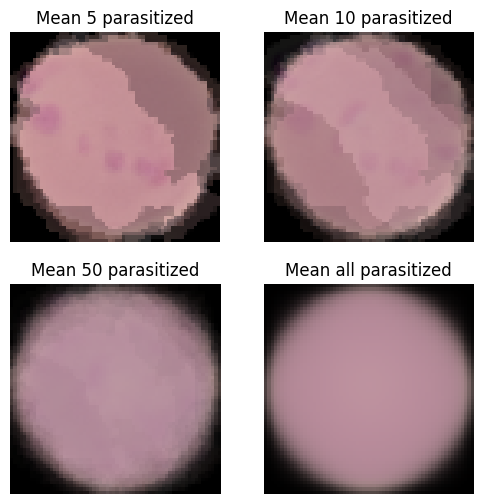

In [22]:
# Show mean of different image samples from all parasitized data
show_mean_increment(parasitized_data, 'parasitized')

<b> Mean image for uninfected

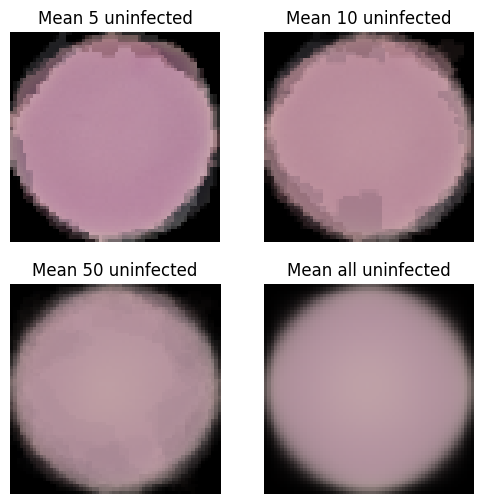

In [23]:
# Show mean of different image samples from all uninfected data
show_mean_increment(uninfected_data, 'uninfected')

####<b> Observations and insights:</b>
Mean of all samples creates a perfect circle, so most data is inside a circle and not in corners.

The mean of parasitized cells is a little more reddish (darker) than uninfected cells.

The "spots" of parasitized cells are distributed across all the cell (not concentrated in the middle).

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [24]:
# Convert RGB images to HSV (Hue, Saturation, Value)
# Create seperate lists for parasitized and uninfected

X_train_hsv = []
parasitized_hsv = []
uninfected_hsv = []

for i,img in enumerate(X_train):
  img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # Convert RGB to HSV
  X_train_hsv.append(img_hsv)
  if y_train[i] == 0:
    uninfected_hsv.append(img_hsv)
  else:
    parasitized_hsv.append(img_hsv)

In [25]:
np.random.seed(42)

# Show H,S,V channels of iamges samples
def show_hsv(images, title, num_samples=5):

  images_copy = images.copy()
  # randomize order of images
  np.random.shuffle(images_copy)

  plt.figure(figsize=(6,2*num_samples))

  for i in range(num_samples):
    h,s,v = cv2.split(images_copy[i])

    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(h, cmap='gray')
    plt.title('Hue')
    plt.axis('off')
    plt.subplot(num_samples,3,i*3 +2)
    plt.imshow(s, cmap='gray')
    plt.title('Saturation')
    plt.axis('off')
    plt.subplot(num_samples,3,i*3 +3)
    plt.imshow(v, cmap='gray')
    plt.title('Value')
    plt.axis('off')

  plt.suptitle('HSV '+ title)
  plt.show()

  del images_copy

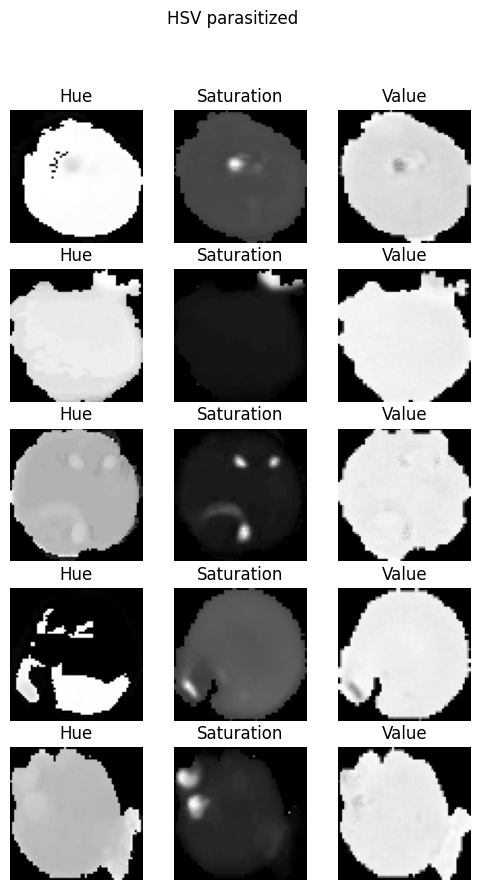

In [26]:
show_hsv(parasitized_hsv, 'parasitized')

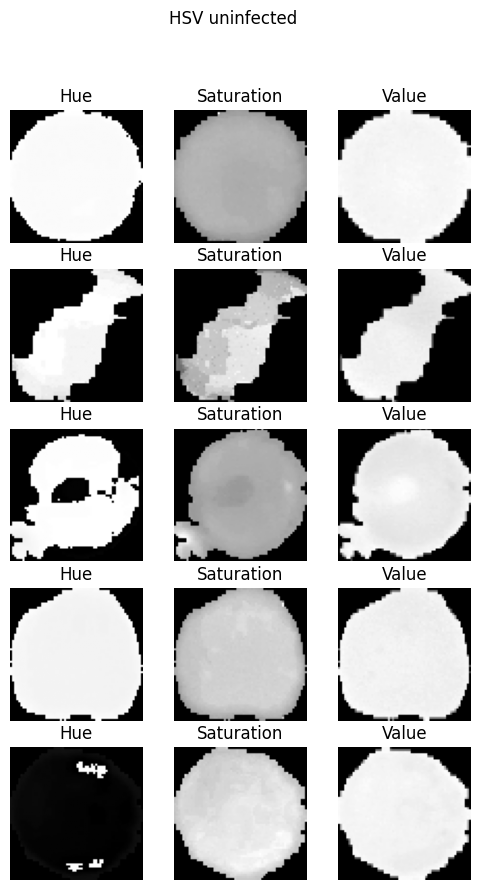

In [27]:
show_hsv(uninfected_hsv, 'uninfected')

###<b> Converting the test data

In [28]:
# Convert RGB images test to HSV (Hue, Saturation, Value)

X_test_hsv = []
for img in X_test:
  img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # Convert RGB to HSV
  X_test_hsv.append(img_hsv)

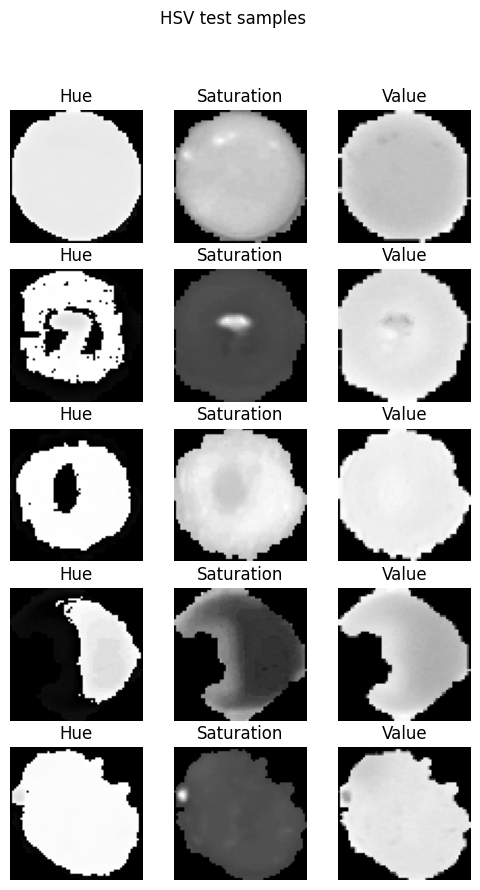

In [29]:
show_hsv(X_test_hsv, 'test samples')

####<b>Observations and insights:</b>
I converted the RGB images to HSV (Hue,Saturation,Value) images.

In seperating H,S,V channels I can observe that parasitized cells has noteable artifacts in the Saturation channel, while uninfected cells have smoother saturation channel.

There is not much difference in Hue (the image color) and Value (the image intensity) channels between infected and uninfected cell.

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [30]:
# Adding Gaussian Blur to X_train

ksize = (5,5) # Gaussian kernel size
sigmaXY = 0   # Standard deviation in X (and y). 0 = automatic calculated

X_train_blur = []
for img in X_train:
  img_blur = cv2.GaussianBlur(img, ksize, sigmaXY)
  X_train_blur.append(img_blur)

X_train_blur = np.array(X_train_blur)

In [31]:
np.random.seed(42)

# Get a random subset to be used for comparing blur results
set_size = 16

X_subset = []
X_subset_blur = []
y_subset = []

total_images = set_size
half = int(total_images/2)

X = X_train.copy()
for i in range(len(X)):

    # Get random index
    rnd_indx = np.random.randint(0, len(X_train))

    # Add uninfected cell image
    if y_subset.count(0) < half and y_train[rnd_indx] == 0:
      X_subset.append(X_train[rnd_indx])
      X_subset_blur.append(X_train_blur[rnd_indx])
      y_subset.append(0)

    # Add parasitized cell image
    elif y_subset.count(1) < (total_images - half) and y_train[rnd_indx] == 1:
      X_subset.append(X_train[rnd_indx])
      X_subset_blur.append(X_train_blur[rnd_indx])
      y_subset.append(1)

    # Exit loop if enough images in X_plot
    if len(X_subset) == total_images:
      break

del X  # Save some memory

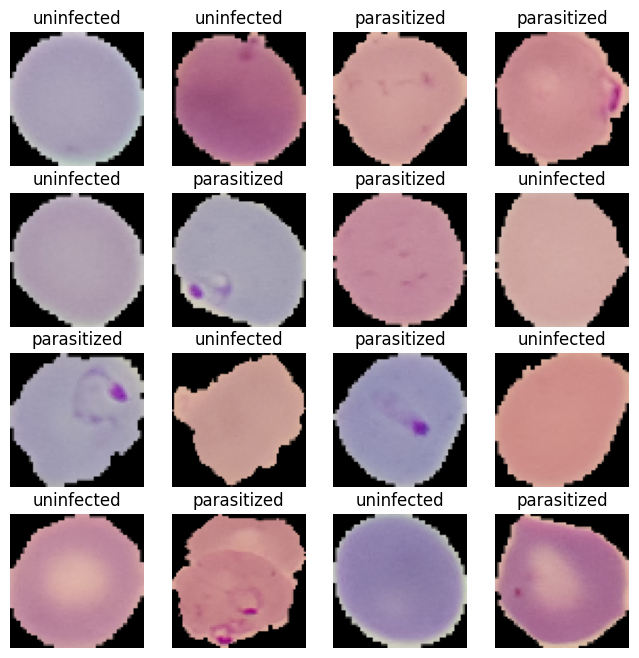

In [32]:
# Plot original images without blur
plot_images_grid(X_subset, y_subset, 4, 4, figsize=(8, 8), randomize=False, balance=False)


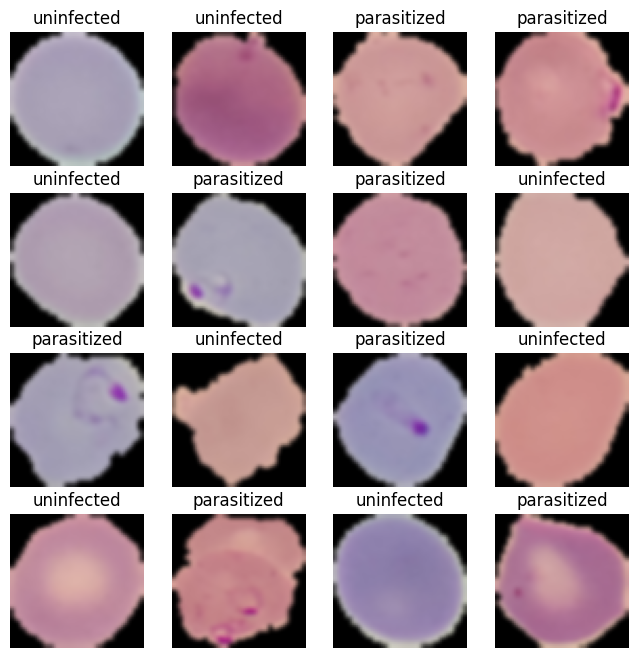

In [33]:
# Plot blurred images
plot_images_grid(X_subset_blur, y_subset, 4, 4, figsize=(8, 8), randomize=False, balance=False)

###<b> Gaussian Blurring on test data

In [34]:
# Adding Gaussian Blur to X_test

ksize = (5,5) # Gaussian kernel size
sigmaXY = 0   # Standard deviation in X (and y). 0 = automatic calculated
num_of_images = 16

X_test_blur = []
for img in X_test:
  img_blur = cv2.GaussianBlur(img, ksize, sigmaXY)
  X_test_blur.append(img_blur)
  if len(X_test_blur) == num_of_images:
    break

X_test_blur = np.array(X_test_blur)

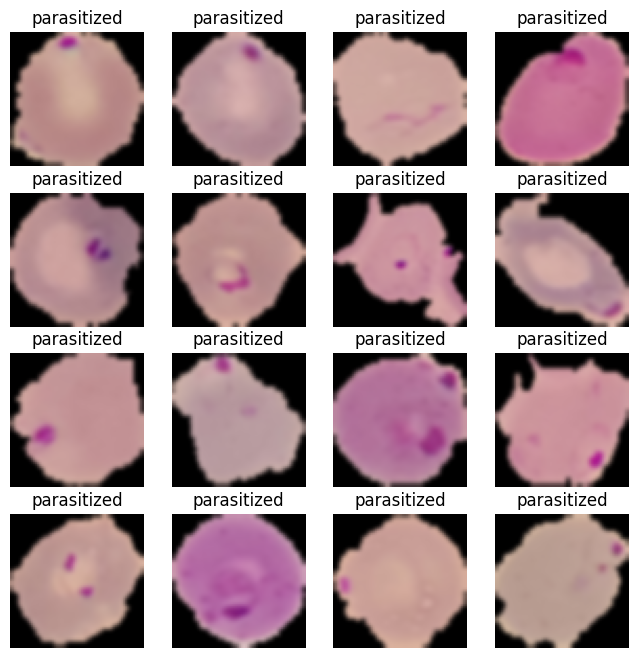

In [35]:
# Plot blurred test images
plot_images_grid(X_test_blur, y_test, 4, 4, figsize=(8, 8), randomize=False,balance=False)

####**Observations and insights:**
Adding Gaussian blur smoothes the images, removes random noise, smooth minor variations and edges.

The blur might help the model focus on the infection features rather than learn on noise and also to generalize and avoid over-fitting.

Adding blur to the data might help with the training of the model.

We can add different blur level to the augmentation.

On the downside, blurring might remove small parasites from the image and hurt the classification of very small parasites.

We can also test other filters to enhance the details of the parasitized cells.


## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [36]:
import numpy as np

# Deep Learning libraries
import tensorflow as tf

import keras


# Importing all the different layers and optimizers
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Clearing backend
from tensorflow.keras import backend

# prediction test reports
from sklearn.metrics import classification_report, confusion_matrix

# Splitting data to train and val
from sklearn.model_selection import train_test_split

# Images augmentation generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random

tf.random.set_seed(42)



In [37]:
# Create a dictionary to store model results for comparison

model_results = {
    'Model': [],
    'val_acc': [],
    'val_loss': [],
    'test_acc': [],
    'test_loss': []
}

In [38]:
# Clearing backend and random seeds

def clear_session():
  backend.clear_session()
  np.random.seed(42)
  random.seed(42)
  tf.random.set_seed(42)

In [39]:
clear_session()

In [40]:
# Free some memory of unused large variables (to save memory and minimize crashes)

try:
  vars_to_delete = [X_train_hsv, X_test_hsv, X_train_blur, X_test_blur, parasitized_hsv, uninfected_hsv, X_subset, X_subset_blur]
  for var in vars_to_delete:
    del var
except NameError:
  pass

####<B>One Hot Encoding the train and test labels

In [41]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

print('Shape of y_train_one_hot: ', y_train_one_hot.shape)
print('Shape of y_test_one_hot: ', y_test_one_hot.shape)

# The problem is binary classification, so I will use only 1 output nueron with
# sigmoid activation function and I won't use the one-hot encoding, which is
# used for categorical with softmax activation.

Shape of y_train_one_hot:  (24958, 2)
Shape of y_test_one_hot:  (2600, 2)


###<b> Building the model

In [42]:
# Building the basic CNN model:
# The model has 3 convolution layers with Relu activation
# A maxpool layer after each Conv layer
# One 256 neurons hidden fully-connected layer
# and one output layer with sigmoid activation (binary).

def cnn_base_model():

  model = Sequential()
  model.add(Input(shape=(64, 64, 3)))

  # 1st Convolutional Layer
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 2nd Convolutional Layer
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 3rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Flatten and Fully Connected Layers
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5)) # Helps prevent overfitting

  # Sigmoid for binary classification
  model.add(Dense(1, activation='sigmoid'))

  return model

model_base = cnn_base_model()

model_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,190,913 (8.36 MB)

 Trainable params: 2,190,913 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

###<b> Compiling the model

In [43]:
model_base.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

<b> Using Callbacks

In [44]:
# Using callback to store best weights after full epochs training
callbacks = [ModelCheckpoint('model_base.mdl_wts.keras', monitor = 'val_loss', save_best_only = True)]

#callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
#             ModelCheckpoint('.mdl_wts.keras', monitor = 'val_loss', save_best_only = True)]

<b> Fit and train our Model

In [45]:
history_base = model_base.fit(X_train, y_train,
                              batch_size = 32, callbacks = callbacks,
                              validation_split = 0.2,
                              shuffle = True,
                              epochs = 20, verbose = 1)


Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7767 - loss: 0.4319 - val_accuracy: 0.9844 - val_loss: 0.0583
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9753 - loss: 0.0738 - val_accuracy: 0.9824 - val_loss: 0.0658
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9803 - loss: 0.0600 - val_accuracy: 0.9746 - val_loss: 0.0848
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9808 - loss: 0.0558 - val_accuracy: 0.9756 - val_loss: 0.0802
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9827 - loss: 0.0501 - val_accuracy: 0.9778 - val_loss: 0.0675
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9828 - loss: 0.0479 - val_accuracy: 0.9772 - val_loss: 0.0754
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9837 - loss: 0.0457 - val_accuracy: 0.9752 - val_loss: 0.0805
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9860 - loss: 0.0376 - val_accuracy: 

###<b> Evaluating the model on test data

In [46]:
# Use the best weights
model_base.load_weights('model_base.mdl_wts.keras')

In [47]:
# Calculate loss and accuracy on test dataset

def model_evaluate(model, xtest, ytest):
    test_loss, test_acc = model.evaluate(xtest, ytest)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    return test_loss, test_acc

In [48]:
test_loss, test_acc = model_evaluate(model_base, X_test, y_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9821 - loss: 0.0432
Test Accuracy: 0.9838
Test Loss: 0.0538


In [49]:
# Function that stores the train results in model_results dictionary
def store_model_results(model_name, history, test_acc, test_loss):
  model_results['Model'].append(model_name)

  model_results['test_acc'].append(round(test_acc,4))
  model_results['test_loss'].append(round(test_loss,4))

  # Get best epoch from history
  best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
  best_val_loss = history.history['val_loss'][best_epoch]
  best_val_accuracy = history.history['val_accuracy'][best_epoch]

  model_results['val_acc'].append(round(best_val_accuracy,4))
  model_results['val_loss'].append(round(best_val_loss,4))

In [50]:
# Store results in model_results

store_model_results('model_base', history_base, test_acc, test_loss)

<b> Plotting the confusion matrix

In [51]:
# Function to print classification report and confusion matrix

def print_report(ytest,ypred):

  # Printing the classification report
  print(classification_report(ytest, ypred))

  # Plotting the heatmap using confusion matrix
  cm = confusion_matrix(ytest, ypred)

  plt.figure(figsize = (8, 5))

  sns.heatmap(cm, annot = True,  fmt = '.0f')

  plt.ylabel('Actual')

  plt.xlabel('Predicted')

  # Display the plot
  plt.show()

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



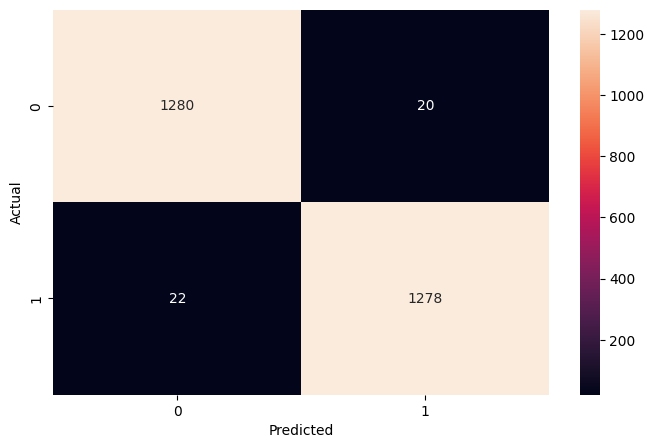

In [52]:
# Predict results on X_test
y_pred = model_base.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int) # Convert logits to binary

# Print test classification report and
print_report(y_test, y_pred)

In [53]:
# Explore the errors
X_test_errors = X_test[y_pred.flatten() != y_test]
y_test_errors = y_test[y_pred.flatten() != y_test]

print('Number of errors:', X_test_errors.shape[0])

Number of errors: 42


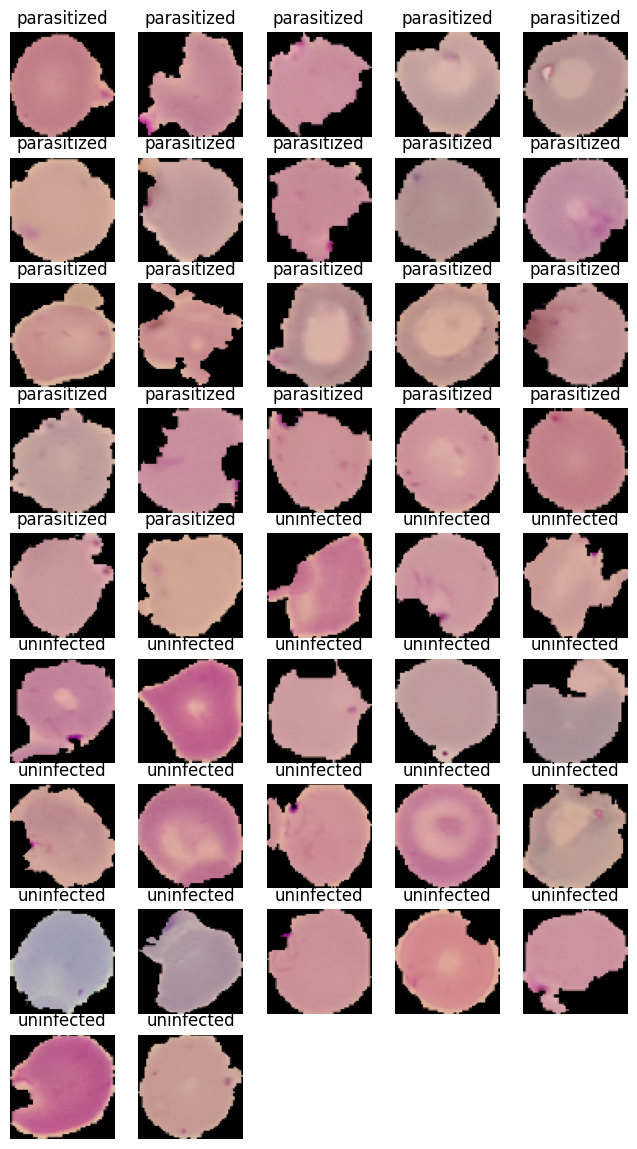

In [54]:
# Visualize the errors

plot_images_grid(X_test_errors, y_test_errors, 10, 5, figsize=(8, 16), randomize=False, balance=False)

<b>Plotting the train and validation curves

In [55]:
# Function to plot model accuracy/loss curves and print test accuracy.

def plot_accuracy_loss(history):

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


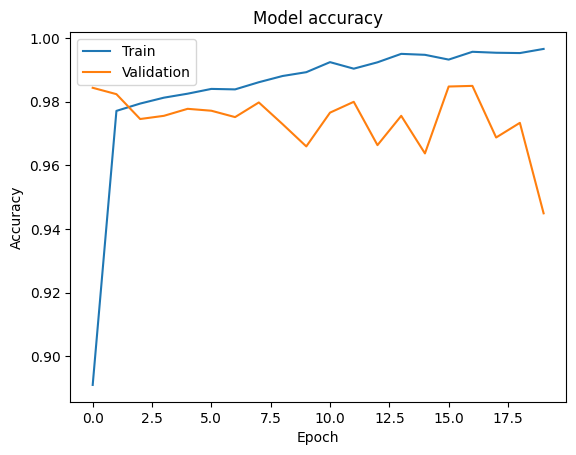

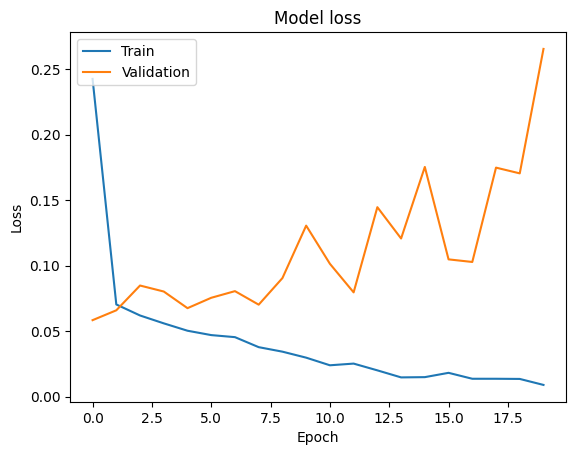

In [56]:
plot_accuracy_loss(history_base)

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [57]:
clear_session()

###<b> Building the Model

In [58]:
# Building CNN model1:
# Add 1 Conv layer for feature extraction and 2 Dense layers for classification
# The model has 4 convolution layers with Relu activation
# A maxpool layer after each Conv layer
# 3 hidden fully-connected layers
# and one output layer with sigmoid activation (binary).

def cnn_model1():

  model = Sequential()
  model.add(Input(shape=(64, 64, 3)))

  # 1st Convolutional Layer
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 2nd Convolutional Layer
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 3rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 4rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Flatten and Fully Connected Layers
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.4)) # Helps prevent overfitting

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3)) # Helps prevent overfitting

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2)) # Helps prevent overfitting

  # Sigmoid for binary classification
  model.add(Dense(1, activation='sigmoid'))

  return model

model1 = cnn_model1()

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 806,593 (3.08 MB)

 Trainable params: 806,593 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

###<b> Compiling the model

In [59]:
model1.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

<b> Using Callbacks</b>

Instead of early stopping I decided to train on all epochs and get the best checkpoint on val_loss. I want to make sure that the training doesn't stop too soon and I want to see the loss graph of all the training session.

In [60]:
# Use callbacks to store best weights after training all epochs
model_weights_file = 'model1.mdl_wts.keras'
callbacks = [ModelCheckpoint(model_weights_file, monitor = 'val_loss', save_best_only = True)]

#callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
#            ModelCheckpoint('.mdl_wts.keras', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [61]:
history1 = model1.fit(X_train, y_train,
                      batch_size = 32, callbacks = callbacks,
                      validation_split = 0.2,
                      shuffle = True,
                      epochs = 20)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.7467 - loss: 0.4547 - val_accuracy: 0.9732 - val_loss: 0.0706
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9770 - loss: 0.0697 - val_accuracy: 0.9593 - val_loss: 0.1128
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9791 - loss: 0.0618 - val_accuracy: 0.9599 - val_loss: 0.1209
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9805 - loss: 0.0579 - val_accuracy: 0.9712 - val_loss: 0.0742
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9820 - loss: 0.0523 - val_accuracy: 0.9671 - val_loss: 0.0999
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9820 - loss: 0.0509 - val_accuracy: 0.9639 - val_loss: 0.0913
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9837 - loss: 0.0496 - val_accuracy: 0.9647 - val_loss: 0.0907
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9829 - loss: 0.0475 - val_accuracy: 

###<b> Evaluating the model

In [62]:
# restore best weights
model1.load_weights(model_weights_file)

In [63]:
test_loss,test_acc = model_evaluate(model1, X_test, y_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9872 - loss: 0.0534
Test Accuracy: 0.9858
Test Loss: 0.0521


In [64]:
# Store results in model_results

store_model_results('model1', history1, test_acc, test_loss)

<b> Plotting the confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1300
           1       0.98      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



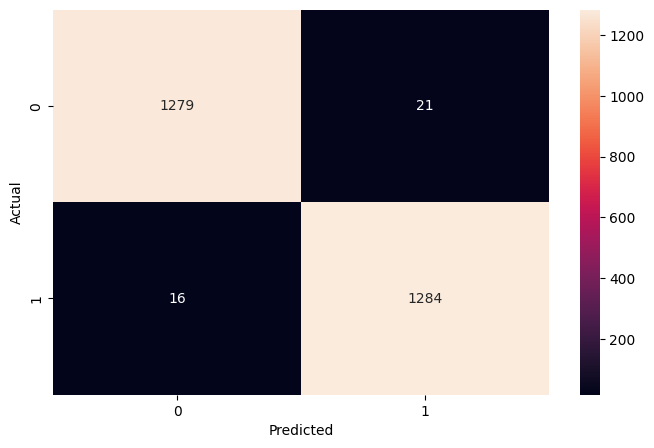

In [65]:
# Predict results on X_test
y_pred = model1.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int) # Convert logits to binary

# Print test classification report and
print_report(y_test, y_pred)

<b> Plotting the train and the validation curves

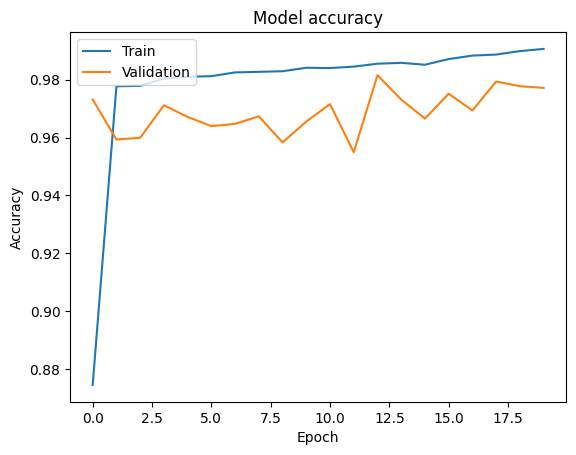

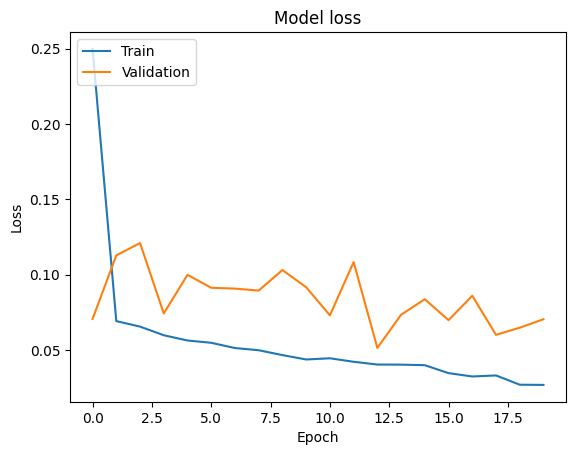

In [66]:
plot_accuracy_loss(history1)

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [67]:
clear_session()

###<b> Building the Model

In [68]:
# Building CNN model2:
# Changeing activiation to LeakeyRelu
# Adding BatchNormalization to Conv layers
# (BatchNorm in Dense layers gave worst results so not adding there)

def cnn_model2():

  model = Sequential()
  model.add(Input(shape=(64, 64, 3)))

  # 1st Convolutional Layer
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 2nd Convolutional Layer
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 3rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 4rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Flatten and Fully Connected Layers
  model.add(Flatten())

  model.add(Dense(256))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.4)) # Helps prevent overfitting

  model.add(Dense(128))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.3)) # Helps prevent overfitting

  model.add(Dense(64))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2)) # Helps prevent overfitting

  # Sigmoid for binary classification
  model.add(Dense(1, activation='sigmoid'))

  return model

model2 = cnn_model2()

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 808,001 (3.08 MB)

 Trainable params: 807,297 (3.08 MB)

 Non-trainable params: 704 (2.75 KB)

###<b>Compiling the model

In [69]:
model2.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

<b> Using callbacks

In [70]:
# Using custom callbacks:
# Store weights of best val_loss epoch but only if the training accuracy is not too low.
# This prevents saving weights of first epoch when val_loss happens to be minimum
# but the model is not trained yet.

class ConditionalWeightSavingCallback(tf.keras.callbacks.Callback):
    def __init__(self, min_accuracy=0.95, filepath='best_model.h5'):
        super(ConditionalWeightSavingCallback, self).__init__()
        self.min_accuracy = min_accuracy
        self.filepath = filepath
        self.best_val_loss = float('inf')  # Initialize with infinity

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        accuracy = logs.get('accuracy')

        if accuracy >= self.min_accuracy and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.model.save_weights(self.filepath, overwrite=True)
            print(f"\nSaving weights with val_loss: {val_loss:.4f} and accuracy: {accuracy:.4f}")

weights_file = 'model2.weights.h5'
callbacks = [ConditionalWeightSavingCallback(min_accuracy=0.95, filepath=weights_file)]

<b>Fit and train the model

In [71]:
history2 = model2.fit(X_train, y_train,
                      batch_size = 32,
                      callbacks = callbacks,
                      validation_split = 0.2,
                      shuffle = True,
                      epochs = 20)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7717 - loss: 0.4751 - val_accuracy: 0.9930 - val_loss: 0.0281
Epoch 2/20
619/624 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9779 - loss: 0.0724
Saving weights with val_loss: 0.0476 and accuracy: 0.9775
624/624 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9779 - loss: 0.0724 - val_accuracy: 0.9808 - val_loss: 0.0476
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9805 - loss: 0.0601 - val_accuracy: 0.9786 - val_loss: 0.0569
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9816 - loss: 0.0537 - val_accuracy: 0.9671 - val_loss: 0.1364
Epoch 5/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9827 - loss: 0.0525
Saving weights with val_loss: 0.0221 and accuracy: 0.9819
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9827 - loss: 0.0525 - val_accuracy: 0.9888 - val_loss: 0.0221
Epoch 6/20
622/624 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9830 - loss: 0.0457
Savi

<b>Plotting the train and validation accuracy

In [72]:
# load best weights
model2.load_weights(weights_file)

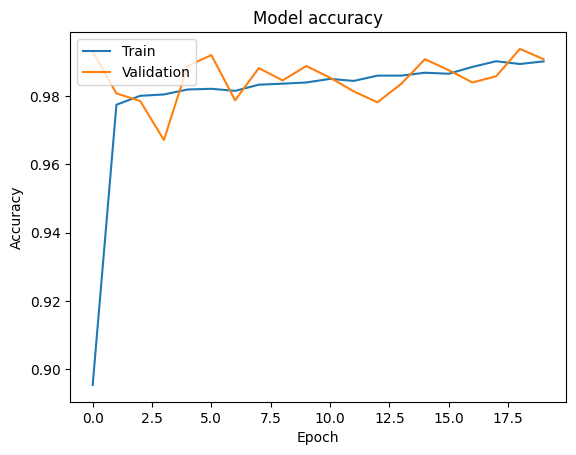

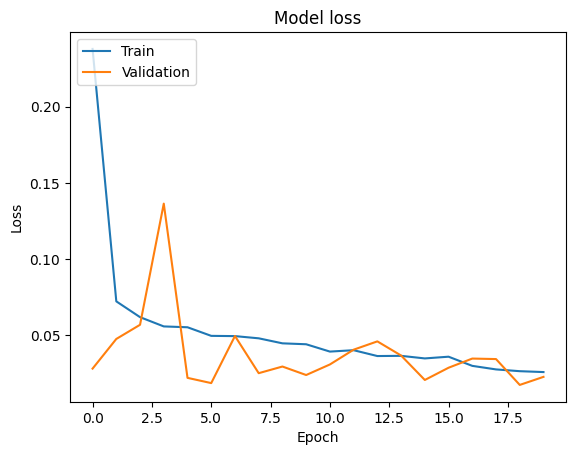

In [73]:
plot_accuracy_loss(history2)


###<b>Evaluating the model

In [74]:
test_loss,test_acc = model_evaluate(model2, X_test, y_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9791 - loss: 0.1939
Test Accuracy: 0.9835
Test Loss: 0.1463


In [75]:
# Store results in model_results

store_model_results('model2', history2, test_acc, test_loss)

<b> Generate the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



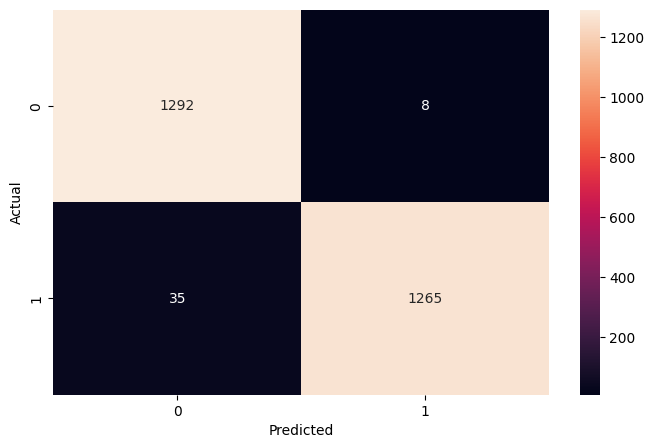

In [76]:
y_pred = model2.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int) # Convert probabilities to binary

# Print test classification report and
print_report(y_test, y_pred)

####<b>Observations and insights:</b>
* Base model gave pretty good results, although the training was not very stable and the val_loss was getting worst.

* Model-1 with additional Conv and Dense layers shows a little improvement to the base layer.

* The val_loss during training of model-1 oscilated around 0.1 and wasn't converging.

* Model-2 added BatchNormalization and LeakyRelu to stabilize the training.

* The training of model-2 converges better and get lower val_loss than model-1, though the results on the test set are not better.

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [77]:
clear_session()

###<b> Use image data generator

In [78]:
# Seperate samples for train and val image generators
X_aug_train, X_aug_val, y_aug_train, y_aug_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.2,
                                                                  random_state = 42)

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(horizontal_flip = True, # do horizontal flip
                                  zoom_range = [0.9, 1.2], # zoom between 0.9 - 1.2
                                  rotation_range = 30,     # rotate image
                                  fill_mode='constant')    # Keep the background black

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_aug_train , y = y_aug_train,
                                     batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_aug_val, y = y_aug_val,
                                  batch_size = 64, seed = 42, shuffle = True)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

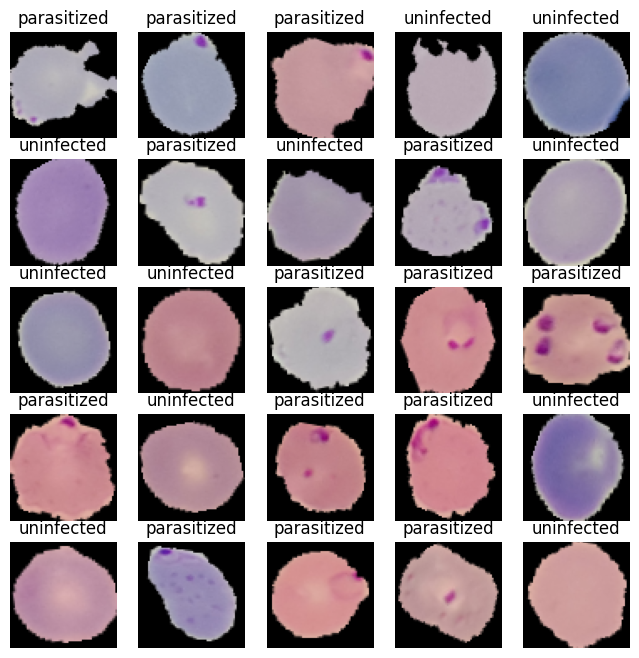

In [79]:
# Creating an iterable for images and labels from the training data
aug_images, aug_labels = next(train_generator)

plot_images_grid(aug_images, aug_labels, 5, 5, figsize=(8, 8), randomize=False, balance=False)

####<b>Observations and insights: </b>
Using augmentation we can add more data samples and generalize the training. It is mostly helpful when the data is too small or too homogeneous.

For augmentation I used horizontal flip, rotation, and zooming. I filled the background with constant black to maintain the shape of the blood cells.

When zooming we need to be carefull not to zoom in/out too much because we can lose the infection spots details in the zoom.

###<b>Building the Model

In [80]:
# Using model 2 that gave better results
# Lets see if augmentation can improve the model

model3 = cnn_model2()

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 808,001 (3.08 MB)

 Trainable params: 807,297 (3.08 MB)

 Non-trainable params: 704 (2.75 KB)

In [81]:
# Compile the model
model3.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

<b>Using Callbacks

In [82]:
# Callbacks to save best weights by min val_loss but only if training accuracy is 0.95 or better

weights_file = 'model3.weights.h5'
callbacks = [ConditionalWeightSavingCallback(min_accuracy=0.95, filepath=weights_file)]

#callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
#             ModelCheckpoint('.mdl_wts.keras', monitor = 'val_loss', save_best_only = True)]

#callbacks = [ModelCheckpoint('model3.mdl_wts.keras', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [83]:
history3 = model3.fit(train_generator,
                      batch_size = 64,
                      callbacks = callbacks,
                      validation_data = val_generator,
                      shuffle = True,
                      epochs = 20)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


312/312 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.7579 - loss: 0.4772 - val_accuracy: 0.7097 - val_loss: 1.1758
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9738 - loss: 0.0830
Saving weights with val_loss: 0.1888 and accuracy: 0.9749
312/312 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.9738 - loss: 0.0830 - val_accuracy: 0.9603 - val_loss: 0.1888
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9776 - loss: 0.0722
Saving weights with val_loss: 0.1437 and accuracy: 0.9780
312/312 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.9777 - loss: 0.0722 - val_accuracy: 0.9611 - val_loss: 0.1437
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9805 - loss: 0.0637
Saving weights with val_loss: 0.0833 and accuracy: 0.9789
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9805 - loss: 0.0637 - val_accuracy: 0.9712 - val_loss: 0.0833
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9797 - loss: 0.0578
Sa

###<B>Evaluating the model

In [84]:
# Load weights from best epoch
model3.load_weights(weights_file)

In [85]:
test_loss,test_acc = model_evaluate(model3, X_test, y_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9869 - loss: 0.0361
Test Accuracy: 0.9854
Test Loss: 0.0407


In [86]:
# Store results in model_results

store_model_results('model3', history3, test_acc, test_loss)

<b>Plot the train and validation accuracy

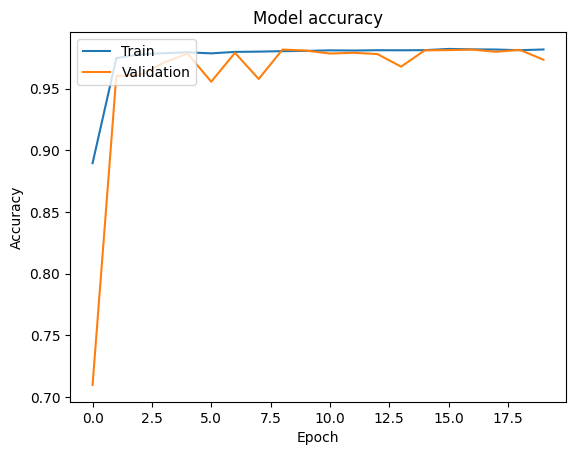

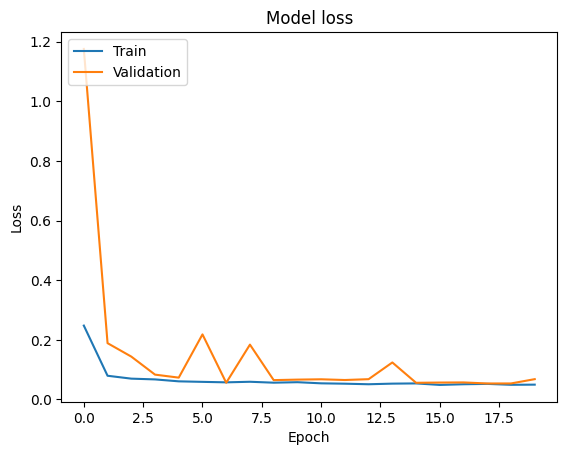

In [87]:
plot_accuracy_loss(history3)

<B>Plotting the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.99      0.98      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



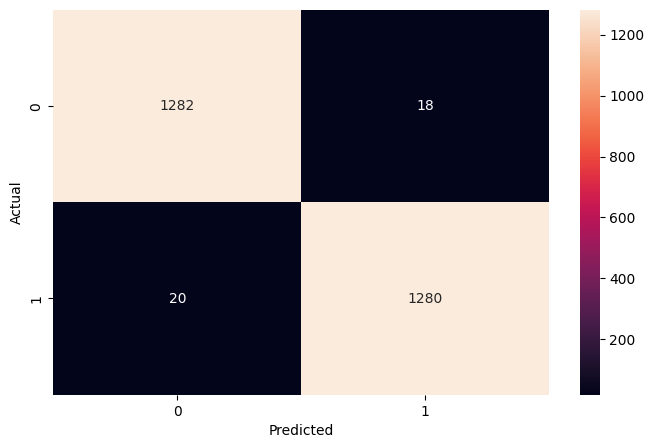

In [88]:
y_pred = model3.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int) # Convert logits to binary

# Print test classification report and
print_report(y_test, y_pred)

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [89]:
clear_session()


In [90]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

# Load pre-trained VGG16 model
vgg = VGG16(include_top = False, # Don't include fully-connected classification layers
            weights = 'imagenet', # Using pre-trained weights
            input_shape = (64, 64, 3))

vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Building the new model based on VGG16

# Use block3 from the VGG model as an input to the classification layers
transfer_layer = vgg.get_layer('block3_pool')

# don't train the pre-trained blocks
vgg.trainable = False

# Add the classification layers
x = Flatten()(transfer_layer.output)  # Flatten the output from the 3rd block of the VGG16 model

# Use same Dense layers as model2
x = Dense(256)(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.4)(x)

x = Dense(128)(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.3)(x)

x = Dense(64)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.2)(x)

# Sigmoid for binary classification
pred = Dense(1, activation='sigmoid')(x)

model4 = Model(vgg.input, pred)


###<b>Compiling the model

In [92]:
# Compile the model
model4.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

<b> using callbacks

In [93]:
# Store weights of best val_loss epoch


weights_file = 'model4.mdl_wts.keras'
callbacks = [ModelCheckpoint(weights_file, monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [94]:
# Training using original data withour augmentation
history4 = model4.fit(X_train, y_train,
                      batch_size = 32,
                      callbacks = callbacks,
                      validation_split = 0.2,
                      shuffle = True,
                      epochs = 20)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.7400 - loss: 0.5100 - val_accuracy: 0.8373 - val_loss: 0.3938
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9088 - loss: 0.2268 - val_accuracy: 0.9876 - val_loss: 0.0608
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9279 - loss: 0.1851 - val_accuracy: 0.8992 - val_loss: 0.3143
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9367 - loss: 0.1667 - val_accuracy: 0.9696 - val_loss: 0.1001
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9418 - loss: 0.1532 - val_accuracy: 0.9637 - val_loss: 0.1189
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9476 - loss: 0.1440 - val_accuracy: 0.9677 - val_loss: 0.1077
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9551 - loss: 0.1257 - val_accuracy: 0.9415 - val_loss: 0.1727
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9553 - loss: 0.1217 - val

<b>Plot the train and validation accuracy

In [95]:
model4.load_weights(weights_file)

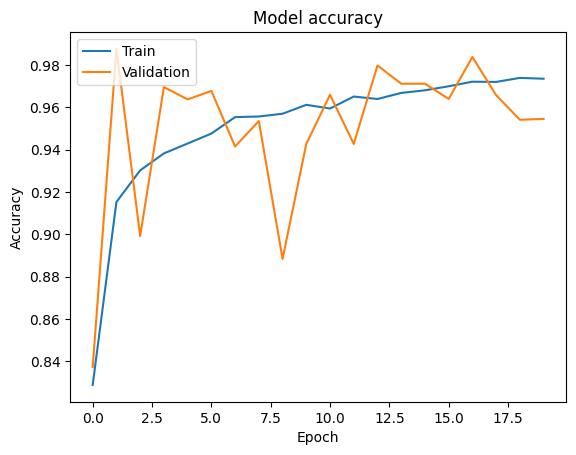

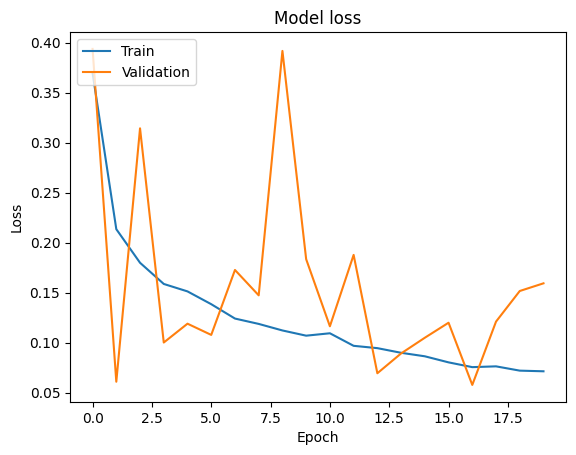

In [96]:
plot_accuracy_loss(history4)

###<b>Observations and insights: </b>

* I used convolution block 3 from VGG. Higher blocks add more complex features (parts of objects such as eyes, wheels etc.) and in our problem and image set these features are not necessary and not helpful.

* Using VGG model doesn't converge well.

###<b> Evaluating the model

In [97]:
test_loss,test_acc = model_evaluate(model4, X_test, y_test)


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9446 - loss: 0.1449
Test Accuracy: 0.9562
Test Loss: 0.1159


In [98]:
# Store results in model_results

store_model_results('model4', history4, test_acc, test_loss)

<b>Plotting the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1300
           1       0.98      0.94      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



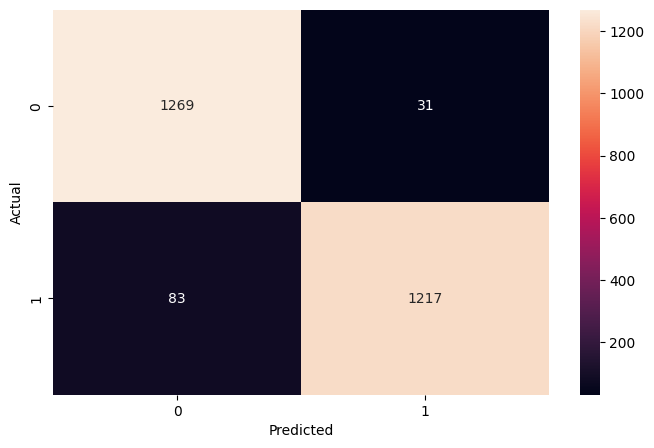

In [99]:
y_pred = model4.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int) # Convert logits to binary

# Print test classification report and
print_report(y_test, y_pred)

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


In [100]:
# Summary of model results:

import pandas as pd

pd.DataFrame(model_results).T

0       1       2       3       4
Model      model_base  model1  model2  model3  model4
val_acc        0.9844  0.9816  0.9938    0.98  0.9838
val_loss       0.0583  0.0513  0.0174  0.0536  0.0576
test_acc       0.9838  0.9858  0.9835  0.9854  0.9562
test_loss      0.0538  0.0521  0.1463  0.0407  0.1159

####<b> Observations and Conclusions drawn from the final model:</b>

* Transfer learning from VGG16 gave the worst results on the test data.
* The most important metric in diseases detection is minimizing False-Negatives which means not detecting the infection. The VGG model gave mostly bad results in detection of infected - 86%.
* VGG learns on totally different type of images (objects, animals, etc.) and uses different features to break down the images. The images of blood cells and paratisized cells use different and simpler features, so we need to train the convolution blocks to learn these features. Training only the classification layers is not enough.
* The model with the best test loss and accuracy is model-3, which is the same as model-2 that was trained using augmented data. Model-3 also converged better during training, and show more balanced errors in the confusion matrix.




**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

<b>Answer - Some improvements that can be suggested:</b>

* HSV images: I will train model-2 with HSV images and compare the results. Testing on augmented data is more complex as the image processing need to be done on RGB images before converting to HSV.
* We can try to improve the selected model (model-3) by:
  * Optimizing hyper-parameters (training parameters, augmentation ranges, dropout values, LeakyRelu alpha.)
  * Retrain using K-Fold cross validation.
  * Fixing the data - the data has some classification errors. We can look for errors in the data using misclassified samples, fix the errors and re-train the model.
  * Adding more layers or changeing the size of the layers.
* Using boosting techniques (such as AdaBoost) to combine multiple weak learners to create a strong classifier.
* Build a hybrid classifier by combining CNN network for feature extraction and Random-Forest (or XGBoost) as classifier.


## <b>Training on HSV images</b>

In [108]:
clear_session()

### Converting the images to HSV and normalizing

In [104]:
# Convert RGB train images to HSV (Hue, Saturation, Value)

X_train_hsv = []

for img in X_train:
  img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # Convert RGB to HSV
  X_train_hsv.append(img_hsv)

X_train_hsv = np.array(X_train_hsv).astype(np.float32)


# Convert RGB test images to HSV (Hue, Saturation, Value)

X_test_hsv = []
for img in X_test:
  img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # Convert RGB to HSV
  X_test_hsv.append(img_hsv)

X_test_hsv = np.array(X_test_hsv).astype(np.float32)

In [105]:
# Checking the range of the data

print ('Before Normalization:')
print ('X_train_hsv Hue pixels range: ', X_train_hsv[:,:,:,0].min(),'-' , X_train_hsv[:,:,:,0].max())
print ('X_train_hsv Saturation pixels range: ', X_train_hsv[:,:,:,1].min(),'-' , X_train_hsv[:,:,:,1].max())
print ('X_train_hsv Value pixels range: ', X_train_hsv[:,:,:,2].min(),'-' , X_train_hsv[:,:,:,2].max())

Before Normalization:
X_train_hsv Hue pixels range:  0.0 - 359.3617
X_train_hsv Saturation pixels range:  0.0 - 0.9999998
X_train_hsv Value pixels range:  0.0 - 1.0


In [106]:
# Normalize Hue channel (assuming range 0-179)
X_train_hsv[:, :, :, 0] = X_train_hsv[:, :, :, 0] / 360.0

# Normalize Saturation and Value channels (assuming range 0-255)
#X_train_hsv[:, :, :, 1] = X_train_hsv[:, :, :, 1] / 255.0
#X_train_hsv[:, :, :, 2] = X_train_hsv[:, :, :, 2] / 255.0
# S and V are already normalized becasue the RGB images were normalized

print('After Normalization:')
print ('X_train_hsv Hue pixels range: ', X_train_hsv[:,:,:,0].min(),'-' , X_train_hsv[:,:,:,0].max())
print ('X_train_hsv Saturation pixels range: ', X_train_hsv[:,:,:,1].min(),'-' , X_train_hsv[:,:,:,1].max())
print ('X_train_hsv Value pixels range: ', X_train_hsv[:,:,:,2].min(),'-' , X_train_hsv[:,:,:,2].max())


After Normalization:
X_train_hsv Hue pixels range:  0.0 - 0.99822694
X_train_hsv Saturation pixels range:  0.0 - 0.9999998
X_train_hsv Value pixels range:  0.0 - 1.0


In [107]:
# Normalize test Hue channel (assuming range 0-179)
X_test_hsv[:, :, :, 0] = X_test_hsv[:, :, :, 0] / 360.0

## Build and compile the model

In [109]:
# Model 5 is based on model-2

model5 = cnn_model2()

model5.summary()

# Compile the model
model5.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 808,001 (3.08 MB)

 Trainable params: 807,297 (3.08 MB)

 Non-trainable params: 704 (2.75 KB)

In [110]:
# Callbacks

weights_file = 'model5.weights.h5'
callbacks = [ConditionalWeightSavingCallback(min_accuracy=0.95, filepath=weights_file)]

In [111]:
# Fit and train the model
history5 = model5.fit(X_train_hsv, y_train,
                      batch_size = 32,
                      callbacks = callbacks,
                      validation_split = 0.2,
                      shuffle = True,
                      epochs = 20)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8223 - loss: 0.4061 - val_accuracy: 0.9778 - val_loss: 0.0693
Epoch 2/20
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9775 - loss: 0.0735
Saving weights with val_loss: 0.0659 and accuracy: 0.9771
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9775 - loss: 0.0735 - val_accuracy: 0.9736 - val_loss: 0.0659
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9805 - loss: 0.0646 - val_accuracy: 0.9631 - val_loss: 0.0973
Epoch 4/20
621/624 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9801 - loss: 0.0560
Saving weights with val_loss: 0.0630 and accuracy: 0.9806
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9801 - loss: 0.0560 - val_accuracy: 0.9736 - val_loss: 0.0630
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9823 - loss: 0.0517 - val_accuracy: 0.9704 - val_loss: 0.0716
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9829 - loss: 0.0499 - v

### **Plot the results**

In [112]:
# Load the best weights
model5.load_weights(weights_file)

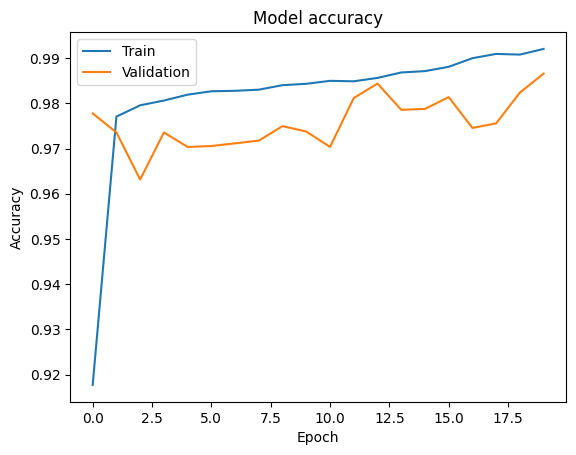

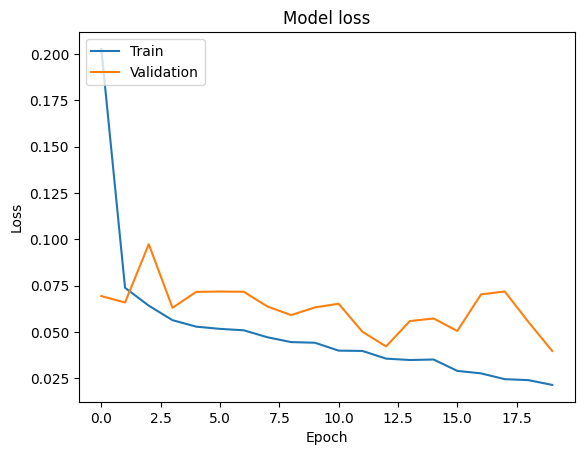

In [114]:
# Plot accuracy and loss
plot_accuracy_loss(history5)

In [115]:
# Evaluate the model
test_loss,test_acc = model_evaluate(model5, X_test_hsv, y_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9798 - loss: 0.1537
Test Accuracy: 0.9812
Test Loss: 0.1209


In [116]:
# Store results in model_results
store_model_results('model5', history5, test_acc, test_loss)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



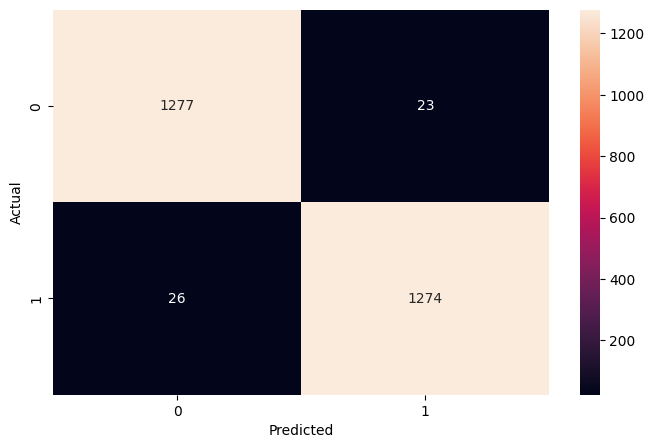

In [117]:
# Generate classification report
y_pred = model5.predict(X_test_hsv)
y_pred = (y_pred >= 0.5).astype(int) # Convert logits to binary

# Print test classification report and confusion matrix
print_report(y_test, y_pred)

## **Summary results of all models**

In [118]:
# Summary of model results:

import pandas as pd

pd.DataFrame(model_results).T

0       1       2       3       4       5
Model      model_base  model1  model2  model3  model4  model5
val_acc        0.9844  0.9816  0.9938    0.98  0.9838  0.9866
val_loss       0.0583  0.0513  0.0174  0.0536  0.0576  0.0397
test_acc       0.9838  0.9858  0.9835  0.9854  0.9562  0.9812
test_loss      0.0538  0.0521  0.1463  0.0407  0.1159  0.1209

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?
  * Visualization of the images shows that parasitized cells tend to have distinct red/purple spots within the cell.
  * The model needs to learn the features related to the spots (color, shape, size, distribution).
  * Cells have a range of colors (red, pink, orange, blue, purple) regardless of infection status so difference in colors is not an indicator.
  * HSV channels could be valuable, espicially the differences found in Saturation channel.
  * The provided data is balanced so there is no bias in training.
  * The data is very different from imagenet data, so using pretrained imagenet data weights doesn't give good results compared to a dedicated trained network.

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?
  * The base model achieved a reasonable level of accuracy, but the training was not stable.
  * Model-1: By adding more convolutional and dense layers to the base model, the model showed a slight improvement in accuracy but still exhibited some instability in validation loss.
  * Model-2: By adding BatchNormalization and LeakyRelu,  training converged little better but the test result wasn't  better than model-1.
  * Model-3: Using data augmentation (horizontal flip, rotation, zoom) to increase data diversity and improve generalization,  showed improvements in training stability and accuracy. It achieved the best results so far.
  * Model-4: Using transfer learning with VGG16 pre-trained model for feature extraction, showed the worst results on the test set accuracy, especially in detection of parasitized cells.
  * Model-5: This is model-2 but training on HSV images. The results are similar to model-2 with RGB. However, adding augmentation to HSV images would be more complex and involve generating augmentation on RGB data before converting to HSV.

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?
  * Model 3 (with augmentation) gave the best results and converged much better, by training on more data and increase data diversity and improve generalization.
  * Model 3 is based on model-2 with augmentation. I should try also augmentation with model-1, as model-2 did not improve  much using BatchNormalization.
  * We can try to improve the model further by:
    * Optimizing hyper-parameters (training parameters, augmentation ranges, dropout values, LeakyRelu alpha.)
    * Re-train using K-Fold cross validation.
    * Fixing the data - the data has some mis-classification errors. We can look for errors in the data using misclassified samples, fix the errors and re-train the model.
    * Testing different sizes of the layers (number of filters, size of dense layers).
    * The most important metric for malaria detection is minimizing False-Negatives. We can use custom loss function that assign higher cost to false negatives.
  